In [1]:
#%reset
%clear

In [1]:
import numpy as np
import tensorflow as tf
import datetime
# this code is used to check whether my gradient calculation can be used
import os
import sys
BASE_DIR = os.getcwd()
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

print('current working dirctory = ',BASE_DIR)

current working dirctory =  /home/chaotang/文档/Try/2D


In [2]:
input_size = 28 * 28
output_size = 28*28
LOG_DIR = BASE_DIR + '/log'
# 设定了一个log 的路径，方便如何存入和读取模型
if not os.path.exists(LOG_DIR): os.mkdir(LOG_DIR)
print('current log dirctory = ',LOG_DIR)

current log dirctory =  /home/chaotang/文档/Try/2D/log


# digit recognition

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train = np.reshape(x_train,[60000,28,28,1])
x_test = np.reshape(x_test,[10000,28,28,1])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [4]:
# 传统的定义方法
def digitNet(x,label):
    conv1 = Conv2D(32,(5,5),activation = 'relu',name = 'conv1')(x)
    #print('conv1',conv1.shape) #(20, 26, 26, 32)
    MP1 = MaxPooling2D(pool_size=(2, 2),name = 'MP1')(conv1)
    #print('MP1',MP1.shape) # (20, 13, 13, 32)
    conv2 = Conv2D(32,(3,3),activation = 'relu',name = 'conv2')(MP1)
    #print('conv2',conv2.shape) # (20, 11, 11, 32)
    MP2 = MaxPooling2D(pool_size=(2, 2),name = 'MP2')(conv2)
    #print('MP2',MP2.shape) # (20, 5, 5, 32)
    # Dp1 =Dropout(rate = 0.2,name = 'Dp1')(MP1)
    # go down one more. Add one more conv and one more mp
    # leave the dp1
    Flat = Flatten()(MP2)
    #print('Flat',Flat.shape) # (20, 800)
    fc1 = Dense(128,activation = 'relu',name = 'fc1')(Flat)
    #out = Dense(10,activation = 'softmax',name = 'out')(fc1)
    #print('fc1',fc1.shape) # (20, 128)
    #Dp1 =Dropout(rate = 0.3,name = 'Dp1')(fc1)
    out = Dense(10,name = 'out')(fc1)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out, labels=label)
    return loss, out

# Training

In [ ]:
# difine two placeholder。This is the old fashion tensorflow method
# 训练数字识别器，loss function选择了和POINTNER++一样的方式去构建 
tf.reset_default_graph()
batchsize = 20
range_val = int(60000/batchsize)

x_pl = tf.placeholder(tf.float32,shape = [None,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [None],name = 'label_pl')
print(x_pl.shape)
print(label_pl.shape)

loss,output = digitNet(x_pl,label_pl)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss)

# add summary writers
saver = tf.train.Saver()
merged = tf.summary.merge_all()


for var in tf.trainable_variables():
    print(var.name)
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
    for epoch in range(7):
        if(epoch % 1 == 0):
            print('this is the ',epoch,' epoch')
        for i in range(range_val):
            batch_index = i
            train_i = x_train[batchsize * batch_index:batchsize * (batch_index + 1),:]
            label_i = y_train[batchsize * batch_index:batchsize * (batch_index + 1)]
            feed = {x_pl:train_i,label_pl:label_i} 
            my_loss ,_ = sess.run([loss,train_op],feed_dict =feed)
            
    # save the model
    save_path = saver.save(sess,os.path.join(LOG_DIR,'BFdigitNet.ckpt'))
    # check the output of the result
    test_img = x_test[0].reshape(1,28,28,1)
    networkoutput = sess.run(output,feed_dict = {x_pl:test_img})
    prediction = np.argmax(networkoutput)
    print('networkoutput',networkoutput.shape)
    print('prediction = ',prediction)
    print('label = ',y_test[0])
    #output_img = networkoutput.reshape((28,28))
    #output_img = (output_img * 255).astype('uint8')
    #plt.imshow(output_img)

# Add noise


test_img (1, 28, 28, 1)
Noise_img (1, 28, 28, 1)


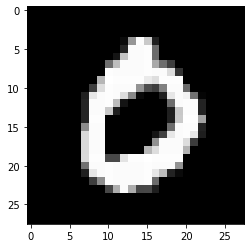

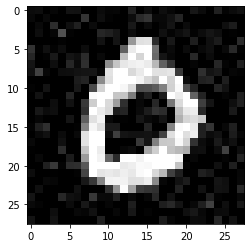

In [35]:
#print('networkoutput = ',networkoutput)
test_index = 3

test_img = x_test[test_index].reshape(1,28,28,1)
test_label = y_test[test_index]
# add Noise
Noise_img = test_img + 0.1* np.random.normal(size = (1,28,28,1))
Noise_img = np.clip(Noise_img,0,1)
print('test_img',test_img.shape)
print('Noise_img',Noise_img.shape)
plt.figure()
plt.imshow(test_img.reshape((28,28)),cmap = 'gray')
plt.figure()
plt.imshow(Noise_img.reshape((28,28)),cmap = 'gray')


# with E(deltaP) = argmax (S(test_label))

In [36]:
# 上面图过后成功完成训练了，接下来就是保存模型并提取模型，然后用自编码模型完成老师的任务了
# restore the model
# also remember to reset_everything to defaut!!!
tf.reset_default_graph()

MODEL_PATH = os.path.join(LOG_DIR,'MydigitNet.ckpt')
# Have to redifine Graph
x_pl = tf.placeholder(tf.float32,shape = [None,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [None],name = 'label_pl')

test_loss,output = digitNet(x_pl,label_pl)

saver = tf.train.Saver()

with tf.Session() as sess: 
    saver.restore(sess, MODEL_PATH)
    print("Model restored.")
    # 设置输出小数点位数
    np.set_printoptions(precision=2)
    print('test_label = ',test_label)
    feed1 = {x_pl:test_img,label_pl:test_label.reshape((1,))}
    networkoutput_re = sess.run(output,feed_dict =feed1)
    print('networkoutput_re',networkoutput_re[0,test_label])
    Origin_prediction = np.argmax(networkoutput_re)
    print('Origin_prediction',Origin_prediction)
    
    feed2 = {x_pl:Noise_img}
    NoiseOutput = sess.run(output,feed_dict =feed2)
    print('NoiseOutput',NoiseOutput[0,test_label])
    Noise_prediction = np.argmax(NoiseOutput)
    print('Noise_prediction',Noise_prediction)

INFO:tensorflow:Restoring parameters from /home/chaotang/文档/Try/2D/log/MydigitNet.ckpt
Model restored.
test_label =  0
networkoutput_re 22.248116
Origin_prediction 0
NoiseOutput 20.33367
Noise_prediction 0


In [37]:
# restore the model
# also remember to reset_everything to defaut!!!
tf.reset_default_graph()

MODEL_PATH = os.path.join(LOG_DIR,'MydigitNet.ckpt')
# Have to redifine Graph
x_pl = tf.placeholder(tf.float32,shape = [None,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [None],name = 'label_pl')

loss,output = digitNet(x_pl,label_pl)

saver = tf.train.Saver()
print('test_label = ',test_label)
deltaX = np.zeros((1,28,28,1))
with tf.Session() as sess: 
    saver.restore(sess, MODEL_PATH)
    print("Model restored.")
    
    for h in range(7):
        for w in range(7):
            example_number = 60000
            block_i = 0.5* np.random.normal(size = [example_number,4,4,1])
            # the first layer is to maintain the original shape
            block_i[0,:,:,:] = 0
            Noisy_stack = np.zeros((example_number,28,28,1))
            for i in range(example_number):
                Noisy_stack[i,:,:,:] = Noise_img
            Noisy_stack[:,4*h:4*h+4,4*w:4*w+4,:] = Noisy_stack[:,4*h:4*h+4,4*w:4*w+4,:] + block_i
            Noisy_stack = np.clip(Noisy_stack,0,1)
            feed = {x_pl:Noisy_stack}
            score = sess.run(output,feed_dict = feed)
            index = np.argmax(score[:,test_label])

            deltaX[:,4*h:4*h+4,4*w:4*w+4,:] = block_i[index,:,:,:]
    # 设置输出小数点位数
    np.set_printoptions(precision=10)
    print('done')
    
    feed1 = {x_pl:test_img}
    output1 = sess.run(output,feed_dict =feed1)
    
    feed2 = {x_pl:Noise_img}
    output2 = sess.run(output,feed_dict =feed2)
    
    feed3 = {x_pl:Noise_img + deltaX}
    output3 = sess.run(output,feed_dict =feed3)

test_label =  0
INFO:tensorflow:Restoring parameters from /home/chaotang/文档/Try/2D/log/MydigitNet.ckpt
Model restored.
done


Original score =  22.248116
Noise score =  20.33367
New score =  51.79607
processed psnr =  8.020842
noisy psnr =  22.823664


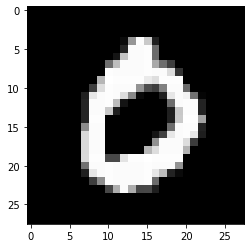

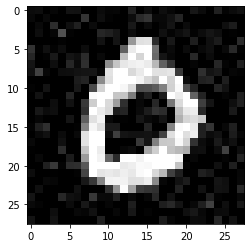

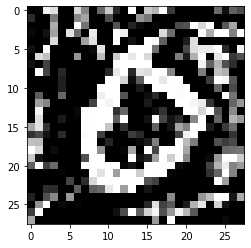

In [38]:
# 设置输出小数点位数
np.set_printoptions(precision=3)
plt.imshow(test_img.reshape((28,28)),cmap='gray')
print('Original score = ',output1[0,test_label])

plt.figure()
plt.imshow(np.clip(Noise_img,0,1).reshape((28,28)),cmap='gray')
print('Noise score = ',output2[0,test_label])
Processed = np.clip(Noise_img + deltaX,0,1)

plt.figure()
plt.imshow(np.clip(Noise_img + deltaX,0,1).reshape((28,28)),cmap='gray')
print('New score = ',output3[0,test_label])

from tensorflow.image import psnr
Processed = Processed.reshape((28,28,1))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    psnr_1 = psnr(test_img[0],Processed,max_val = 1.0)
    psnr_2 = psnr(test_img[0],Noise_img[0],max_val = 1.0)
    output_1,output_2 = sess.run([psnr_1,psnr_2])
    print('processed psnr = ',output_1)
    print('noisy psnr = ',output_2)


# 下面的代码除了恢复模型以外什么都干不了

# 下面这个失败了，基本确定没什么吉尔用

In [ ]:
# 上面图过后成功完成训练了，接下来就是保存模型并提取模型，然后用自编码模型完成老师的任务了
# restore the model
# also remember to reset_everything to defaut!!!
tf.reset_default_graph()

MODEL_PATH = os.path.join(LOG_DIR,'BFdigitNet.ckpt')
# Have to redifine Graph
x_pl = tf.placeholder(tf.float32,shape = [None,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [None],name = 'label_pl')

test_loss,output = digitNet(x_pl,label_pl)

saver = tf.train.Saver()

with tf.Session() as sess: 
    saver.restore(sess, MODEL_PATH)
    print("Model restored.")
    # 设置输出小数点位数
    np.set_printoptions(precision=3)
    print('test_label = ',test_label)
    test_label_stack = np.full(5,test_label)
    print(test_label_stack)
    
    Noise_img_iter = Noise_img
    
    deltaX = np.zeros((28,28,1))
    for epoch in range(1):  
        
        deltaX = np.zeros((28,28,1))   
        
        for height in range(28):
            for width in range(28):
                Min_index

                Noisycopy = Noise_img_iter
                Noisystack = np.zeros((5,28,28,1))

                # define offset Matrix
                minus2 = np.zeros((28,28,1))
                minus2[height,width,0] = -0.2

                minus1 = np.zeros((28,28,1))
                minus1[height,width,0] = -0.1

                plus1 = np.zeros((28,28,1))
                plus1[height,width,0] = 0.1

                plus2 = np.zeros((28,28,1))
                plus2[height,width,0] = 0.2

                Noisystack[0] = Noisycopy 
                Noisystack[1] = Noisycopy + minus2
                Noisystack[2] = Noisycopy + minus1
                Noisystack[3] = Noisycopy + plus1
                Noisystack[4] = Noisycopy + plus2

                feed = {x_pl:Noisystack,label_pl:test_label_stack}
                _,current_output = sess.run([test_loss,output],feed_dict =feed)
                Min_index = np.argmax(current_output[:,test_label])
                deltaX[height,width] = Min_index          
                # print('Min_index',Min_index)#current_output[:,test_label])
                deltaX[deltaX == 1] = -0.2
                deltaX[deltaX == 2] = -0.1
                deltaX[deltaX == 3] = 0.1
                deltaX[deltaX == 4] = 0.2

        Noise_img_iter = Noise_img_iter + deltaX
    print('done')
    
    feed1 = {x_pl:Noise_img}
    output1 = sess.run(output,feed_dict =feed1)
    
    feed2 = {x_pl:test_img}
    output2 = sess.run(output,feed_dict =feed2)